# Solutions Task 4
Author: Luis Denninger 

## Imports

In [1]:
import os
from functools import reduce
from pathlib import Path as P

import numpy as np

import torch
import torch.nn 
import torch.nn.functional as fun
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

import torchvision as tv

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
import matplotlib.patches as patches
import seaborn as sn
from sklearn.metrics import confusion_matrix

import yaml

import copy

from tqdm import tqdm

import optuna

import pandas as pd

import plotly

from fvcore.nn import FlopCountAnalysis, flop_count_str, ActivationCountAnalysis

import ipdb

import inspect

import torchgadgets as tg

## Data

In [2]:
tg.tools.set_random_seed(42)

data = tg.data.load_dataset('oxfordpet')


train_dataset = data['train_dataset']
test_dataset = data['test_dataset']

dog_inds = [1, 2, 3, 4, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21,22, 24, 25, 28, 29, 30, 31, 34, 35, 36]
cat_inds = [0, 5, 6, 7, 8, 11, 20, 23, 26, 27, 32, 33]

category_names = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle',
    'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau',
    'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees',
    'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher',
    'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard',
    'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier',
    'wheaten_terrier', 'yorkshire_terrier'
]



  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxfordpet/oxford-iiit-pet/images.tar.gz to data/oxfordpet/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxfordpet/oxford-iiit-pet/annotations.tar.gz to data/oxfordpet/oxford-iiit-pet


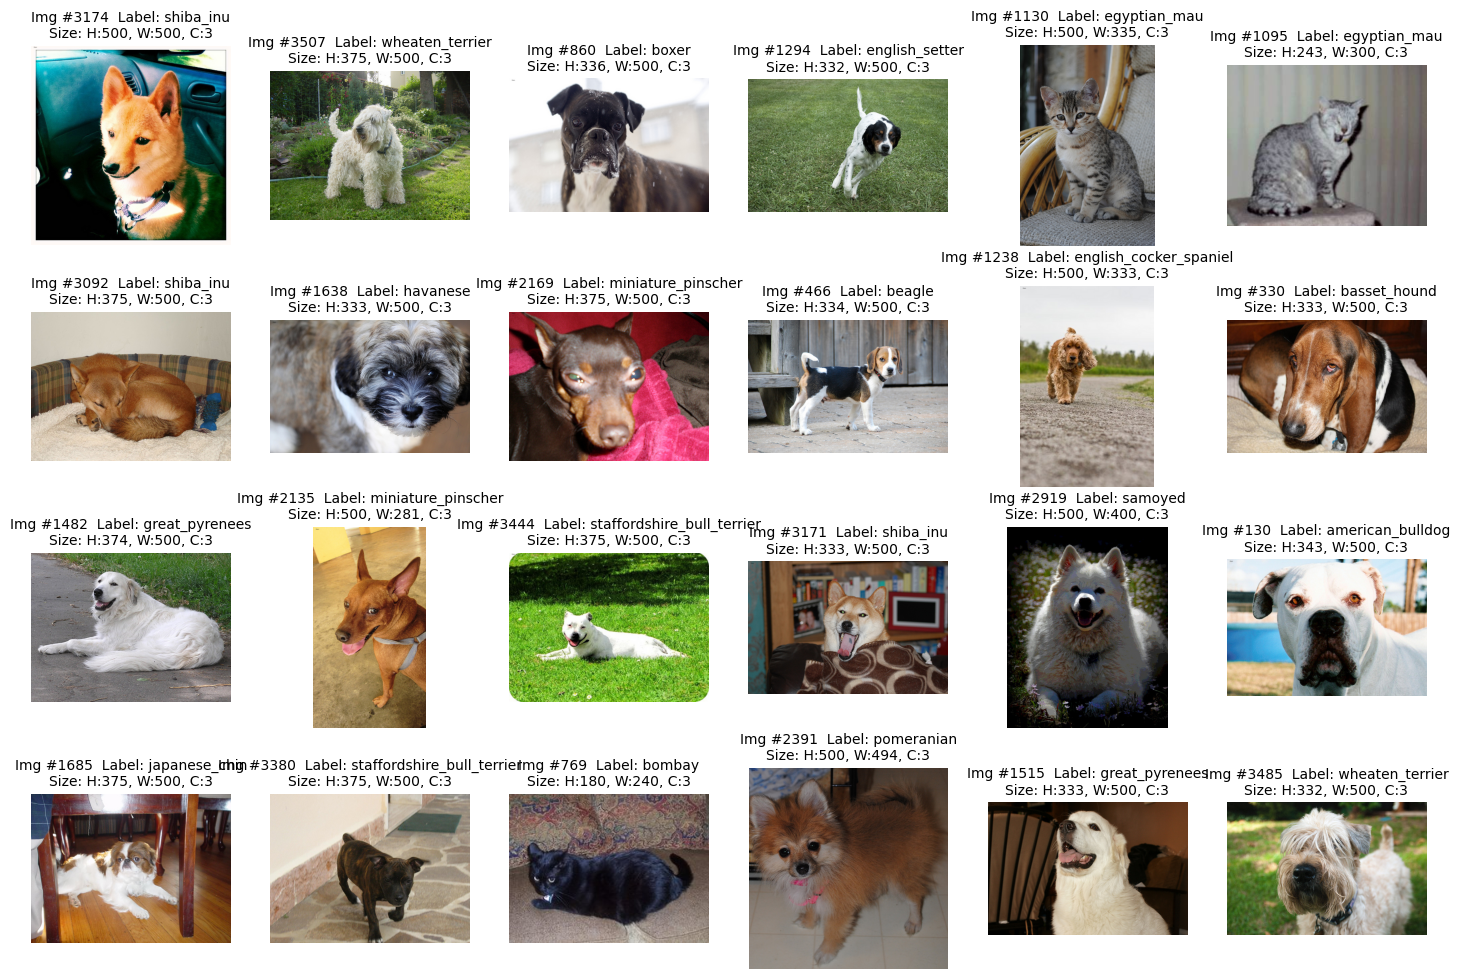

In [3]:
tg.visualization.visualize_dataset(test_dataset, label_names=category_names, layout=(4,6))

In [3]:
train_pre_loading_transforms = [    {'type': 'convert_255_to_1','train': True, 'eval': True}, 
                                    {'type': 'random_resized_crop', 'size': (224, 224), 'scale': (0.08,1.0), 'ratio': (0.75, 1.3333), 'train': True, 'eval': False}
                                ]
test_pre_loading_transforms = [{'type': 'convert_255_to_1','train': True, 'eval': True},
                                {'type': 'dynamic_center_crop', 'train': False, 'eval': True},
                                {'type': 'resize', 'size': (224,224), 'train': False, 'eval': True}]

tg_train_dataset = tg.data.ImageDataset(train_dataset, transforms = train_pre_loading_transforms)
tg_test_dataset = tg.data.ImageDataset(test_dataset, transforms = test_pre_loading_transforms)

In [8]:
data_augmentation =   [   
                        #{'type': 'cutmix', 'alpha': 300, 'prob': 0.2, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'mixup', 'alpha': 1.0, 'prob': 0.5, 'beta': 1.0, 'num_classes': 2, 'train': True, 'eval': False},
                        {'type': 'random_rotation','degrees': 5, 'train': True, 'eval': False},
                        {'type': 'random_horizontal_flip','prob': 0.3, 'train': True, 'eval': False},
                        {'type': 'color_jitter', 'brightness': 0.4, 'contrast': 0.4, 'saturation': 0.3, 'hue': 0.0, 'train': True, 'eval': False},
                        {'type': 'gaussian_blur', 'kernel_size':(5,5), 'sigma': (0.1,2.0), 'train': True, 'eval': False},
                        {'type': 'normalize', 'train': True, 'eval': True},
                    ]

RESNET_MODEL_ARCHITECTURE =     [
                                    {'type': 'ResNet', 'size': 18, 'remove_layer': 1, 'weights': 'DEFAULT'},
                                    {'type': 'flatten'},
                                    {'type': 'dropout', 'prob': 0.3},
                                    {'type': 'linear', 'in_features': tg.models.RESNET_FEATURE_DIM[18][1], 'out_features': 2}
                                ]


RESNET_MODEL_CONFIG =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': 20,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': data_augmentation,
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG)

RESNET_MODEL_CONFIG_NO_AUGM =  {
                            'layers': RESNET_MODEL_ARCHITECTURE,
                            'output_dim': 2,
                            'activation': 'relu',
                            'batch_size': 32,
                            'num_epochs': 20,
                            'num_iterations': 0,
                            'learning_rate': 0.00003,
                            'random_seed': 22,
                            'pre_processing': [],
                            'evaluation': {
                                'metrics': ['accuracy'],
                                'frequency': 1
                            },
                            'dataset': {
                                    'name': 'oxfordpets',
                                    'train_size': 2000,
                                    'val_size': 0,
                                    'test_size': 3669,
                                    'train_shuffle': True,
                                    'eval_shuffle': False,
                                    'drop_last': True,
                                    'classes': [0, 1]
                            },
                            'scheduler': {'epoch_scheduler': {'type': 'exponential', 'gamma': 0.9}, 'iteration_scheduler': None},
                            'optimizer': {'type': 'Adam'}
                            
                        }
RESNET_MODEL_CONFIG_NO_AUGM['num_iterations'] = tg.training.get_num_iterations(RESNET_MODEL_CONFIG_NO_AUGM)



In [10]:
import json

path = 'config'

with open(os.path.join(path, 'data_augmentation.json'), 'w') as f:
    json.dump(data_augmentation, f, indent=4)